In [1]:
import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Functions import Gaussian, Schmidt, Exponential, Lowdin, Lrz, Overlap, modified_Schmidt
import matplotlib.pyplot as plt
import scipy as sc
from tabulate import tabulate

In [2]:
# Calculate the probability of an outcome for detector
def calculate_proba(n,m,measure,allstateprobs_iterator):
    r"""
    gives the probability of an output measurement
    :param n: number of spatial states
    :param m: number of internal states
    :param measure: array of how much photon we expect for each captor (array 1,n)
    :param allstateprobs_iterator: An iterator containing states and probabilities of the simulation
    :return: float probability
    """
    Proba = 0
    k = 0
    theta = np.pi/4
    c = [np.cos(theta),np.sin(theta)]
    for state, probabilitie in allstateprobs_iterator:
        ls = list(state)
        #print(state,probabilitie)
        capt = []
        for i in range(n):
            capt.append(np.sum(ls[i::n]))
        #print(capt)
        if np.all(capt==measure):
            #print(state)
            #print(probabilitie)
            Proba += probabilitie
        k+=1
    return Proba

def create_inputs(enterFunc,Coefs,Dictionnary = None): 
    #enterFunc is the distribution in space of the entry in the system ex: [1,1]
    if any(np.array(enterFunc)>1):
        raise Exception('Cannot be more than 1 photon per spatial mode')
        
    internMode = np.sum(enterFunc)
    spatialMode = len(enterFunc)
    nbPhoton = np.sum(enterFunc)
    L = spatialMode*internMode 

    Inputs = []
    for x in itertools.combinations(range(L), nbPhoton) :
        inputsTemps = [1 if i in x else 0 for i in range(L)]
        Inputs.append(np.array(inputsTemps))
    
    realInputs = []

    for i in range(len(Inputs)):
        compare = np.zeros(spatialMode)
        for ii in range(0,L,spatialMode):
            compare += Inputs[i][ii:ii+spatialMode]

        if np.all(compare == enterFunc):
            realInputs.append(Inputs[i])
    #print(realInputs)
    c = []
    Arr = np.squeeze(Coefs)
    
    for i in range(len(realInputs)):
        ArrCond = np.array(realInputs[i]).reshape(internMode,spatialMode).T
        y = np.ma.masked_array(Arr, abs(ArrCond-1))
        c.append(np.prod(y))

    k = 0

    if isinstance(Dictionnary,dict) and len(Dictionnary)!=0:
        testdict = {}

        iterkeys = itertools.permutations(Dictionnary.keys(),2)
        iterval = itertools.permutations(Dictionnary.values(),2)
        for i,j in zip(iterkeys,iterval) :
            dictkey = '|' + i[0] + ',' + i[1] + '>'
            dictval = j[0] + j[1]
            testdict[dictkey] = pcvl.BasicState(dictval)
        for i in realInputs:
            nameOfState = str(pcvl.BasicState(i))
            if k == 0:
                InputsBS = testdict[nameOfState]
                
            else:
                InputsBS = InputsBS + testdict[nameOfState]

            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS,testdict
    else:     
        for i in realInputs:
            if k == 0 :
                InputsBS = pcvl.BasicState(i)
            else :
                InputsBS = InputsBS + pcvl.BasicState(i)
            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS

Test CNOT

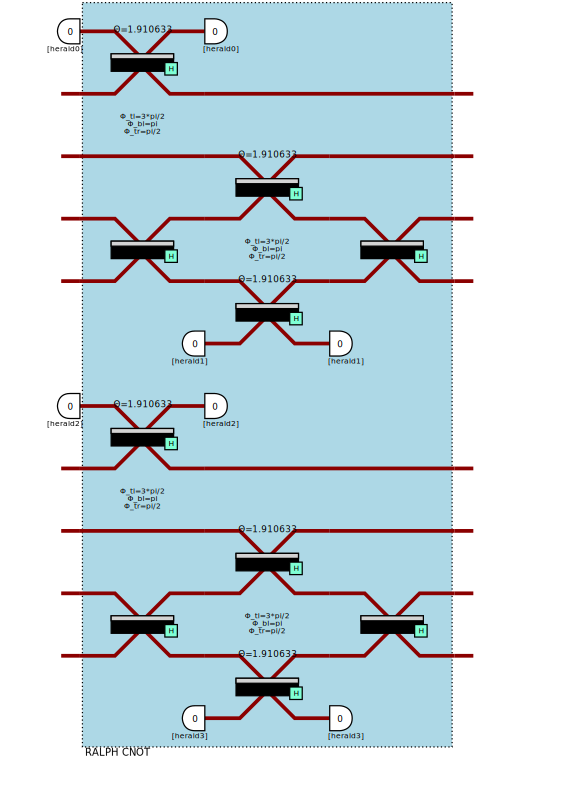

In [3]:
n = 3 #Nombre de modes spatiaux
m = 3 #Nombre de modes internes
k = 3 #Nombre de photon
cnot = pcvl.Circuit(12, name="Ralph CNOT")
cnot.add((0, 1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((3, 4), pcvl.BS.H())
cnot.add((2, 3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((4, 5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((3, 4), pcvl.BS.H())
#first copy
cnot.add((6, 7), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((9, 10), pcvl.BS.H())
cnot.add((8, 9), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((10, 11), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((9, 10), pcvl.BS.H())

p = pcvl.Processor("Naive", cnot)
p.set_postprocess(lambda s: (s[1] or s[2] or s[7] or s[8]) and (s[3] or s[4] or s[9] or s[10]))
p.add_herald(0, 0)
p.add_herald(5, 0)
p.add_herald(6, 0)
p.add_herald(11, 0)

pcvl.pdisplay(p, recursive = True)




In [ ]:
statesdict = {
    "0,0": [1, 0, 1, 0],
    "0,1": [1, 0, 0, 1],
    "1,0": [0, 1, 1, 0],
    "1,1": [0, 1, 0, 1]
}



In [4]:
## Getting the c vector 
env_type = 1  # 1=Gaussian, 2=exponential
N = 100  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

sigma_wave = 0.5  # standard deviation of wave function
x = np.linspace(-16 * sigma_wave, 16 * sigma_wave, N)  # position values

shift_list=np.linspace(-8*sigma_wave,8*sigma_wave,100)
C2S=np.zeros(len(shift_list))

for k in range(len(shift_list)):
    shift=shift_list[k]
    x_shift=np.array([0,shift])
    for i in range(N_shift):
        waves[i] = Gaussian(x-x_shift[i], sigma_wave)

    new_base,coeffsS=Schmidt(waves,x)
    new_base,coeffsL = Lowdin(waves,x)
    C2S[k]=coeffsS[1,1]

In [7]:
## Getting the c vector 
env_type = 1  # 1=Gaussian, 2=exponential
N = 100  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

sigma_wave = 0.5  # standard deviation of wave function
x = np.linspace(-32 * sigma_wave, 32 * sigma_wave, N)  # position values

shift_list=np.linspace(-16*sigma_wave,16*sigma_wave,100)
C2MGS=np.zeros(len(shift_list))


for k in range(len(shift_list)):
    shift=shift_list[k]
    x_shift=np.array([0,shift])
    for i in range(N_shift):
        waves[i] = Exponential(x-x_shift[i], sigma_wave)


    new_base,coeffsMGS = modified_Schmidt(waves,x)
    C2MGS[k] = coeffsMGS[1,1]

In [8]:
Probs = []
for coef in C2MGS:
    C = np.array([[0,0],[1,0],[0,0],[np.sqrt(1-coef ** 2),coef]])
    InputsBS = create_inputs([0,1,0,1],C)

    #print(InputsBS)


    pcvl.pdisplay(p, recursive = True)
    realOutput = {}
    for i in range(len(InputsBS)):
        miniState = InputsBS[i]
        #print(miniState,':',InputsBS[miniState])
        p.with_input(miniState)
        output = p.probs()['results']
        for ii in output.keys():
            if ii in realOutput.keys():
                realOutput[ii] = realOutput[ii] + output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
            else:
                realOutput[ii] = output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
    K = 0

    for i,j in zip(realOutput.keys(),realOutput.values()):
        #print(i,j)
        K += j

    #print(K)
    realOutputLs = list(realOutput.values())
    Probs.append(realOutputLs[0])



/var/folders/p8/vpf48gmj0r176vk8xpbpy47w0000gn/T/ipykernel_8324/1538191092.py:3: RuntimeWarning: invalid value encountered in sqrt
  C = np.array([[0,0],[1,0],[0,0],[np.sqrt(1-coef ** 2),coef]])


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(shift_list/1e9,Probs)
plt.xlabel(r'$\Delta z$')
plt.ylabel(r'$P(11 \rightarrow 10)$')

plt.show()

Create Random Values

In [49]:
## Getting the c vector 
env_type = 1  # 1=Gaussian, 2=exponential
N = 10000  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

sigma_wave = 0.5  # standard deviation of wave function
x = np.linspace(-32 * sigma_wave, 32 * sigma_wave, N)  # position values

shift_list=np.random.standard_cauchy(10)*sigma_wave/10

C2MGS=np.zeros(len(shift_list))
C2S = np.zeros_like(C2MGS)

for k in range(len(shift_list)):
    shift=shift_list[k]
    x_shift=np.array([0,shift])
    for i in range(N_shift):
        waves[i] = Exponential(x-x_shift[i], sigma_wave)


    new_base,coeffsMGS = modified_Schmidt(waves,x)
    new_base,coeffsS=Schmidt(waves,x)
    new_base,coeffsL = Lowdin(waves,x)
    C2S[k]=coeffsS[1,1]
    C2MGS[k] = coeffsMGS[1,1]

In [46]:
def create_CRand(i,coef):
    CRand = []
    RawInputs = []
    Expected = []
    if i==0:
        CRand.append(np.array([[1,0],[0,0],[np.sqrt(1-coef ** 2),coef],[0,0]])) #Input = [1,0,1,0] = 0,0 exp = 0,0
        RawInputs.append([1,0,1,0])
        Expected = [1,0,1,0]
    elif i==1:
        CRand.append(np.array([[1,0],[0,0],[0,0],[np.sqrt(1-coef ** 2),coef]])) #Input = [1,0,0,1] = 0,1 exp = 0,1
        RawInputs.append([1,0,0,1])
        Expected = [1,0,0,1]
    elif i==2:
        CRand.append(np.array([[0,0],[1,0],[np.sqrt(1-coef ** 2),coef],[0,0]])) #Input = [0,1,1,0] = 1,0 exp = 1,1
        RawInputs.append([0,1,1,0])
        Expected = [0,1,0,1]
    elif i==3:
        CRand.append(np.array([[0,0],[1,0],[0,0],[np.sqrt(1-coef ** 2),coef]])) #Input = [0,1,0,1] = 1,1 exp = 1,0
        RawInputs.append([0,1,0,1])
        Expected = [0,1,1,0]
    else :
        print('Epic Fail')
        return
    return CRand, np.squeeze(RawInputs), Expected

In [50]:
print(C2S)

[0.05654732 0.05653184 0.09773287 0.08923382 0.27179975 0.18593142
 0.14878081 0.23344501 0.24599314 0.30531105]


In [43]:
# Create the C manually because it is not yet implemented
statesdict = {
    pcvl.BasicState([1,0,1,0]) : "00",
    pcvl.BasicState([1,0,0,1]) : "01",
    pcvl.BasicState([0,1,1,0]) : "10",
    pcvl.BasicState([0,1,0,1]) : "11"
}


In [60]:
TableValue = []

for vars in range(4):

    statesProb = dict.fromkeys(statesdict.keys(),0)

    for coef in C2MGS:
        
        [C,Inputs,Expected] = create_CRand(vars,coef)
        InputsBS = create_inputs(Inputs,C)

        #print(InputsBS)


        pcvl.pdisplay(p, recursive = True)
        realOutput = {}
        for i in range(len(InputsBS)):
            miniState = InputsBS[i]
            #print(miniState,':',InputsBS[miniState])
            p.with_input(miniState)
            output = p.probs()['results']
            for ii in output.keys():
                if ii in realOutput.keys():
                    realOutput[ii] = realOutput[ii] + output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
                else:
                    realOutput[ii] = output[ii] * abs(InputsBS[InputsBS[i]]) ** 2

        
        Prob = 0
        
        for states,val in zip(realOutput.keys(),realOutput.values()):
            ls = np.array(states)
            Cond = ls[0:4] + ls[4:]
            tempState = pcvl.BasicState(Cond)
            #print(tempState,val)
            if tempState in statesProb.keys():
                statesProb[tempState] += val

    results = {key: value / len(C2MGS) for key, value in statesProb.items()}
    TableValue.append(results)

In [61]:
table = [[] for i in range(len(statesdict.keys())+1)]
table[0] = list(statesdict.values())
k = 1
for i in statesdict.keys():
    l = 0
    for j in statesdict.keys():
        if l==0:
            table[k].append(statesdict[i])

        table[k].append(TableValue[k-1][j])
        
        l += 1
    k += 1

In [62]:
from tabulate import tabulate
print(table[4])
print(tabulate(table,headers='firstrow',tablefmt="fancy_grid"))

['11', 0.0, 0.0, 0.9193911398279407, 0.08060886017205923]
╒════╤══════╤══════╤═══════════╤═══════════╕
│    │   00 │   01 │        10 │        11 │
╞════╪══════╪══════╪═══════════╪═══════════╡
│ 00 │    1 │    0 │ 0         │ 0         │
├────┼──────┼──────┼───────────┼───────────┤
│ 01 │    0 │    1 │ 0         │ 0         │
├────┼──────┼──────┼───────────┼───────────┤
│ 10 │    0 │    0 │ 0.0806089 │ 0.919391  │
├────┼──────┼──────┼───────────┼───────────┤
│ 11 │    0 │    0 │ 0.919391  │ 0.0806089 │
╘════╧══════╧══════╧═══════════╧═══════════╛


In [40]:
with open('shiftlist.txt','w+') as f:
    f.writelines(str(x_shift))
    f.writelines('\n')
    f.writelines(str(table))
